In [1]:
import cprv1.cprv1 as cpr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cprv1.cprv1 as cpr
from wmf import wmf
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
#from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate,Paragraph, Table, TableStyle
from IPython.display import IFrame
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.enums import TA_LEFT, TA_CENTER
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

def latex_table_from_df(self,df,caption,label,columns,cellwidth,width=5.6):
    df = df.fillna(-999)
    cellwidth = (np.array(cellwidth,float)/100)*width
    vspace=0.1
    ncols = df.columns.size+1
    table = []
    table.append('\\begin{table}[h!]')
    table.append('\\caption{%s}'%caption)
    table.append('\\vspace{%smm}'%vspace)
    table.append('\\fontsize{10}{2} \selectfont{')
    # textwidth
    textwidth = ''
    for i in map(lambda x:"p{%.3f in}"%x,cellwidth):
        textwidth+='%s '%i
    table.append("\\scalebox{1.0}{\\begin{tabularx}{\\textwidth}{%s}"%textwidth)
    # INICIO DE TABLA
    table.append('\\rowcolor{CiceBlue2}')
    # COLUMNAS
    columnas = ''
    for i in map(lambda x: '& \\textbf{\\textcolor{white}{%s}} '%x,columns):
        columnas += i
    table.append('\\rowcolor{CiceBlue2}')
    table.append('\\textbf{\\textcolor{white}{''}}')
    table.append(columnas)
    table.append('\\rule[-0.1cm]{0cm}{0.7cm}\\\\')
    # VALORES
    for j in range(df.index.size):
        rows = ''
        def f(x):
            try:
                x='& %.2f '%x
            except:
                x=''
            return x
        for i in map(lambda x: f(x),df.iloc[j]):
            rows += i

        table.append('\\textbf{%s}'%df.index[j])
        table.append(rows)
        table.append('\\rule[-0.1cm]{0cm}{0.7cm}\\\\ \\cline{1-%d}'%ncols)


    #table.append("\\textbf{%s}"%df.columns[0])
    #table.append(columnas)

    table.append('\\label{%s}'%(label))
    table.append('\\end{tabularx}}}')
    table.append('\\end{table}')
    table.append('\\clearpage')
    return table

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')
    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return (x, y)

def get_sections(levantamiento,level):
        hline = ((levantamiento['x'].min()*1.1,level),(levantamiento['x'].max()*1.1,level)) # horizontal line
        lev = pd.DataFrame.copy(levantamiento) #df to modify
        #PROBLEMAS EN LOS BORDES
        borderWarning = 'Warning:\nProblemas de borde en el levantamiento'
        if lev.iloc[0]['y']<level:
            print '%s en banca izquierda'%borderWarning
            lev = pd.DataFrame(np.matrix([lev.iloc[0]['x'],level]),columns=['x','y']).append(lev)
        if lev.iloc[-1]['y']<level:
            print '%s en banca derecha'%borderWarning
            lev = lev.append(pd.DataFrame(np.matrix([lev.iloc[-1]['x'],level]),columns=['x','y']))
        condition = (lev['y']>=level).values
        flag = condition[0]
        nlev = []
        intCount = 0
        ids=[]
        for i,j in enumerate(condition):
            if j==flag:
                ids.append(i)
                nlev.append(list(lev.iloc[i].values))
            else:
                intCount+=1
                ids.append('Point %s'%intCount)
                line = (list(lev.iloc[i-1].values),list(lev.iloc[i].values)) #  #puntoA
                inter = line_intersection(line,hline)
                nlev.append(inter)
                ids.append(i)
                nlev.append(list(lev.iloc[i].values))
            flag = j
        df = pd.DataFrame(np.matrix(nlev),columns=['x','y'],index=ids)
        dfs = []
        for i in np.arange(1,100,2)[:intCount/2]:
            dfs.append(df.loc['Point %s'%i:'Point %s'%(i+1)])
        return dfs


def plot_section(df,escalado=False,*args,**kwargs):
        '''Grafica de la seccion transversal de estaciones de nivel
        |  ----------Parametros
        |  df : dataFrame con el levantamiento topo-batimetrico, columns=['x','y']
        |  level : Nivel del agua
        |  riskLevels : Niveles de alerta
        |  *args : argumentos plt.plot()
        |  **kwargs : xSensor,offset,riskLevels,xLabel,yLabel,ax,groundColor,fontsize,figsize,
        |  Nota: todas las unidades en metros'''
        # Kwargs
        level = kwargs.get('level',None)
        xLabel = kwargs.get('xLabel','Distancia desde la margen izquierda [m]')
        yLabel = kwargs.get('yLabel','Profundidad [m]')
        waterColor = kwargs.get('waterColor','blue')
        groundColor = kwargs.get('groundColor','#%02x%02x%02x' % (8,31,45))
        fontsize= kwargs.get('fontsize',14)
        figsize = kwargs.get('figsize',(10,4))
        riskLevels = kwargs.get('riskLevels',None)
        xSensor = kwargs.get('xSensor',None)
        offset = kwargs.get('offset',None)
        scatterSize = kwargs.get('scatterSize',0.0)
        alpha = kwargs.get('alpha',0.9)
        ax = kwargs.get('ax',None)
        # main plot
        if ax is None:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
        if escalado == True:
            ax.set_aspect(1)
        ax.plot(df['x'].values,df['y'].values,color='k',lw=0.5)
        ax.fill_between(np.array(df['x'].values,float),np.array(df['y'].values,float),float(df['y'].min()),color=groundColor,alpha=alpha)
        # waterLevel
        sections = []
        if level is not None:
            for data in get_sections(df,level):
                #ax.hlines(level,data['x'][0],data['x'][-1],color='k',linewidth=0.5)
                ax.fill_between(data['x'],level,data['y'],color=waterColor,alpha=alpha)
                sections.append(data)
        # Sensor
        if (offset is not None) and (xSensor is not None):
            ax.scatter(xSensor,level,marker='v',color='k',s=30+scatterSize,zorder=22)
            ax.scatter(xSensor,level,color='white',s=120+scatterSize+10,edgecolors='k')
            #ax.annotate('nivel actual',xy=(label,level*1.2),fontsize=8)
            #ax.vlines(xSensor, level,offset,linestyles='--',alpha=0.5,color=self.colores_siata[-1])
        #labels
        ax.set_xlabel(xLabel)
        ax.set_facecolor('white')
        #risks
        xlim_max = df['x'].max()
        if riskLevels is not None:
            x = df['x'].max() -df['x'].min()
            y = df['y'].max() -df['y'].min()
            factorx = 0.05
            ancho = x*factorx
            locx = df['x'].max()+ancho/2.0
            miny = df['y'].min()
            locx = 1.03*locx
            risks = np.diff(np.array(list(riskLevels)+[offset]))
            ax.bar(locx,[riskLevels[0]+abs(miny)],width=ancho,bottom=0,color='green')
            colors = ['yellow','orange','red','red']
            for i,risk in enumerate(risks):
                ax.bar(locx,[risk],width=ancho,bottom=riskLevels[i],color=colors[i],zorder=19)

            if level is not None:
                ax.hlines(data['y'].max(),data['x'].max(),locx,lw=1,linestyles='--')
                ax.scatter([locx],[data['y'].max()],s=30,color='k',zorder=20)
            xlim_max=locx+ancho
#        ax.hlines(data['y'].max(),df['x'].min(),sections[0].min(),lw=1,linestyles='--')
        ax.set_xlim(df['x'].min(),xlim_max)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.set_ylabel(yLabel)
        #plt.savefig('/home/mcano/Desktop/batimetria.png',bbox_inches='tight')

def estima_velocidad_media_vertical(self,vertical,factor=0.6,v_index=0.8):
    vertical = vertical[vertical.index!='vm']
    index = list(vertical.index)
    if index == ['vertical','x','y']:
        if vertical['x'] == 0.0:
            vm = factor * self.seccion.loc[vertical.name+1,'vm']
        else:
            vm = factor * self.seccion.loc[vertical.name-1,'vm']
    elif (index == ['vertical','x','y','vsup']) or (index == ['vertical','x','y','v08']):
        try:
            vm = v_index*vertical['vsup']
        except:
            vm = v_index*vertical['v08']
    elif (index == ['vertical','x','y','v04']) or (index == ['vertical','x','y','v04','vsup']):
        vm = vertical['v04']
    elif index == (['vertical','x','y','v04','v08']) or index == (['vertical','x','y','v04','v08','vsup'])  :
        vm = (2*vertical['v04']+vertical['v08'])/3.0
    elif index == ['vertical','x','y','v08','vsup']:
        vm = v_index*vertical['vsup']
    elif (index == ['vertical','x','y','v02','v04','v08']) or (index == ['vertical','x','y','v02','v04','v08','vsup']):
        vm = (2*vertical['v04']+vertical['v08']+vertical['v02'])/4.0
    return vm


def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


def plot_riskLevel(df,bbox_to_anchor = (-0.15, 1.09),figsize=(6,14),ruteSave = None,legend=False,fontsize=20):
    import matplotlib.colors as mcolors
    from matplotlib.patches import Rectangle
    df = df.loc[df.index[::-1]]
    c = mcolors.ColorConverter().to_rgb
    cm = make_colormap([c('green'),0.20,c('#f2e71d'),0.4,c('orange'),0.60,c('red'),0.80,c('red')])
    fig = plt.figure(figsize=figsize)
    im = plt.imshow(df.values, interpolation='nearest', vmin=0, vmax=4, aspect='equal',cmap=cm);
    #cbar = fig.colorbar(im)
    ax = plt.gca();
    ax.set_xticks(np.arange(0,df.columns.size, 1));
    ax.set_yticks(np.arange(0, df.index.size, 1));
    ax.set_xticklabels(df.columns,fontsize=fontsize);
    ax.set_yticklabels(df.index,fontsize=fontsize,ha = 'left');
    ax.set_xticks(np.arange(-.5, df.columns.size, 1), minor=True,);
    ax.set_yticks(np.arange(-.5, df.index.size, 1), minor=True);
    plt.draw()
    yax = ax.get_yaxis()
    pad = max(T.label.get_window_extent().width*1.05 for T in yax.majorTicks)
    yax.set_tick_params(pad=pad)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    #ax.text(-0.4,df.index.size+0.5,'NIVELES DE RIESGO\n %s - %s'%(start,pd.to_datetime(end).strftime('%Y-%m-%d')),fontsize=16)
    alpha=1
    height = 8
    if legend == True:
        p1 = Rectangle((0, 0), 1, height, fc="green",alpha=alpha)
        p2 = Rectangle((0, 0), 1, height, fc="orange",alpha=alpha)
        p3 = Rectangle((0, 0), 1, height, fc="red",alpha=alpha)
        p4 = Rectangle((0, 0), 1, height, fc="indigo",alpha=alpha)
        #p2 = Rectangle((0, 0), 1, 1, fc="red")
        leg = ax.legend([p1,p2,p3,p4], [u'N1',u'N2',u'N3',u'N4'],
                   ncol=3,bbox_to_anchor=bbox_to_anchor,fontsize=fontsize)
    if ruteSave is None:
        pass
    else:
        plt.savefig(ruteSave,format='pdf',bbox_inches='tight')

import matplotlib.font_manager as fm
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def rain_area_metropol(self,vec,ax,f=1):
    cmap_radar,levels,norm = self.radar_cmap()
    extra_lat,extra_long = self.adjust_basin(fac=0.02)
    extra_long=0
    extra_lat=0
    kwargs = {}
    contour_keys={'cmap'  :cmap_radar,
                'levels':levels,
                'norm'  :norm}
    perimeter_keys={'color':'k','linewidth':1}



    longs,lats=self.longitude_latitude_basin()
    x,y=np.meshgrid(longs,lats)
    y=y[::-1]
    # map settings
    m = Basemap(projection='merc',llcrnrlat=lats.min()-0.05*f, urcrnrlat=lats.max()+0.05*f,
    llcrnrlon=longs.min()-0.05*f, urcrnrlon=longs.max()+0.1*f, resolution='c',**kwargs)
    # perimeter plot
    xp,yp = m(self.Polygon[0], self.Polygon[1])
    m.plot(xp, yp,**perimeter_keys)
    # vector plot
    if vec is not None:
        map_vec,mxll,myll=wmf.cu.basin_2map(self.structure,vec,len(longs),len(lats),self.ncells)
        map_vec[map_vec==wmf.cu.nodata]=np.nan
        xm,ym=m(x,y)
        contour = m.contourf(xm, ym, map_vec.T, 25,**contour_keys)
    else:
        contour = None

    m.readshapefile('/media/nicolas/maso/Mario/shapes/AreaMetropolitana','area',linewidth=0.5,color='w')
    m.readshapefile('/media/nicolas/maso/Mario/shapes/net/%s/%s'%(self.codigo,self.codigo),str(self.codigo))
    m.readshapefile('/media/nicolas/maso/Mario/shapes/streams/%s/%s'%(self.codigo,self.codigo),str(self.codigo))


    x,y = m(self.info.longitud,self.info.latitud)
    #m.scatter(x,y,s=100,zorder=10)
    scatterSize=100
    m.scatter(x,y,color='grey',s=120+scatterSize+60,edgecolors='grey',zorder=39)
    m.scatter(x,y,color='w',s=120+scatterSize+60,edgecolors='k',zorder=40)
    m.scatter(x,y,marker='v',color='k',s=20+scatterSize,zorder=41)

    municipios = [m.area_info[i]['Name'] for i in range(10)]
    patches=[]
    for info,shape in zip(m.area_info,m.area):
        patches.append(Polygon(np.array(shape),True),)
    ax = plt.gca()
    ax.add_collection(PatchCollection(patches,color='grey',edgecolor='w',zorder=1,alpha=0.3,label='asdf'))

    #m.readshapefile('/media/nicolas/maso/Mario/shapes/polygon/145/145','sabanetica',zorder=100)

    for frame in ['top','bottom','right','left']:
        ax.spines[frame].set_color('w')
    cbar = m.colorbar(contour,location='right',pad="5%")
    #cbar.set_label('Lluvia acumulada [mm]', rotation=270)
    #plt.savefig('mapa_lluvia.png',bbox_inches='tight')
    
def plot_gif(count,fecha,f=1,**kwargs):
    series = nivel.copy()
    series[count:] = np.NaN
    vect = rain_vect.copy()
    vect = vect.drop(vect.index[count:])
    s = rain.copy()
    s[count:] = np.NaN
    level = series.dropna().iloc[-1]/100.0
    vec = vect.sum().values/1000.0
    scatterSize = 70
    figsize=(18,14)
    series = pd.Series.copy(series/100.0)
    risk_levels = np.array(self.risk_levels,float)/100.0
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.3)
    #gs = GridSpec(3, 3)
    ax1 = fig.add_subplot(2,2,1)
    # identical to ax1 = plt.subplot(gs.new_subplotspec((0,0), colspan=3))
    ax2 = fig.add_subplot(2,2,2,sharey=ax1)
    ylimit = kwargs.get('ylimit',max(risk_levels)*1.05)
    series.plot(ax=ax1,label='',color='w',linewidth=0.001,fontsize=fontsize,**kwargs)
    #ax1.fill_between(series.index,series.values,color=self.colores_siata[0])
    ax1.fill_between(series.index, series.values,color=self.colores_siata[1],label='Open values')
    #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d %b'))
    alpha=0.2
    ymax = max([bat['y'].max(),risk_levels[-1]])
    ax1.set_xlim(series.index[0],series.index[-1]+datetime.timedelta(minutes=5))
    sections =self.plot_section(bat,
                           ax = ax2,
                           level=level,
                           riskLevels=risk_levels,
                           xSensor=self.info.x_sensor,
                           scatterSize=scatterSize)
    ax1.spines['top'].set_color('w')
    ax1.spines['right'].set_color('w')
    ax2.spines['top'].set_color('w')
    ax2.spines['right'].set_color('w')
    ax2.spines['right'].set_color('w')
    ax1.set_ylabel('Profundidad [m]')
    ax1.set_xlim(rain.index[0],rain.index[-1])
    ax1.scatter(series.dropna().index[-1],level,marker='v',color='k',s=30+scatterSize,zorder=22)
    ax1.scatter(series.dropna().index[-1],level,color='white',s=120+scatterSize+10,edgecolors='k')
    ax3 = fig.add_subplot(2,2,3,sharex=ax1)
    s.plot(ax=ax3,color='w',linewidth=0.001,fontsize=fontsize)
    ax3.fill_between(s.index, s.values,color=self.colores_siata[3],label='O')
    ax3.spines['top'].set_color('w')
    ax3.spines['right'].set_color('w')
    ax3.spines['right'].set_color('w')
    ax4 = fig.add_subplot(2,2,4)
    rain_area_metropol(self,vec,ax4,f=f)
    ax2.set_ylim(0,ymax)
    #cb = plt.colorbar(ax, cax = cbaxes)  
    #cb.set_level('[mm]')

    ax1.set_title(u'Profundidad de la lámina de agua')
    ax2.set_title(u'Sección transversal del canal')
    ax3.set_title(u'Lluvia promedio en la cuenca')
    ax3.set_ylabel('Intensidad promedio [mm/h]',fontsize=fontsize)
    ax4.set_title(u'Lluvia acumulada [mm]')
    ax3.set_ylim(0,rain.max())
    ax3.set_xlim(rain.index[0],rain.index[-1])
    plt.suptitle(u'%s | %s'%(self.info.nombre,fecha))
    plt.savefig('%s/%.3d.png'%(filepath,count),
                bbox_inches='tight')
def get_aforos(self):
    aforos = self.read_sql("SELECT %s from aforo_nueva where id_estacion_asociada = '%s'"%(parametros,self.codigo))
    aforos = aforos.set_index('id_aforo')
    aforos[aforos==-999]=np.NaN
    aforos = aforos.dropna()
    aforos = aforos.sort_values('fecha')
    aforos['levantamiento']=False
    for id_aforo in aforos.index:
        if get_levantamiento(self,id_aforo).index.size:
            aforos.loc[id_aforo,'levantamiento'] = True
    return aforos

def get_seccion(self,id_aforo):
    seccion = self.read_sql("SELECT * FROM seccion_aforo_nueva WHERE id_aforo = '%s'"%(id_aforo)).set_index('vertical')
    return seccion[['x','y','velocidad04','velocidad08','caudal04','area']].sort_index()


def get_levantamiento(self,id_aforo):
    seccion = self.read_sql("SELECT * FROM levantamiento_aforo_nueva WHERE id_aforo = '%s'"%(id_aforo)).set_index('vertical')
    return seccion[['x','y']].sort_index()
    
    
def plot_sections(self):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    aforos = get_aforos(self)
    for count,id_aforo in enumerate(aforos.index):
        seccion = get_seccion(self,id_aforo)
        seccion.plot(x='x',y='y',ax=ax)

    for count,id_aforo in enumerate(aforos.index):
        fig = plt.figure(figsize=(8,4))
        seccion = get_seccion(self,id_aforo)
        ax = fig.add_subplot(1,1,1)
        seccion.plot(x='x',y='y',ax=ax)
        ax.scatter(seccion['x'].values,seccion['y'].values)
        
        
        title = ''
        count = 0
        for name,value in zip(aforos.reset_index().columns,[id_aforo]+list(aforos.loc[id_aforo].values)):
            try:
                value = round(value,2)
            except:
                pass
            title+='%s:%s   '%(name,value)
            if count >= 1:
                title+='\n'
                count = 0
            else:
                count+=1
        ax.set_title(title)
    
    
def excel_to_df(file):
    df = pd.read_excel(file)
    df = df.loc[df['x'].dropna().index]
    df['vertical'] = range(1,df.index.size+1)
    df['y'] = df['y'].abs()*-1
    df.columns = map(lambda x:x.lower(),df.columns)
    ax = df.plot(x='x',y='y')
    ax.set_xlim(-1,df['x'].max()+1)
    ax.set_title("path:'%s'"%file,fontsize=12)
    return df

def estima_velocidad_media_vertical(self,vertical,factor=0.0,v_index=0.8):
    vertical = vertical[vertical.index!='vm']
    index = list(vertical.index)
    if index == ['vertical','x','y']:
        vm = 0
    elif (index == ['vertical','x','y','v_sup']) or (index == ['vertical','x','y','v08']):
        try:
            vm = v_index*vertical['v_sup']
        except:
            vm = v_index*vertical['v08']
    elif (index == ['vertical','x','y','v04']) or (index == ['vertical','x','y','v04','v_sup']):
        vm = vertical['v04']
    elif index == (['vertical','x','y','v04','v08']) or index == (['vertical','x','y','v04','v08','v_sup'])  :
        vm = (2*vertical['v04']+vertical['v08'])/3.0
    elif index == ['vertical','x','y','v08','v_sup']:
        vm = v_index*vertical['v_sup']
    elif (index == ['vertical','x','y','v02','v04','v08']) or (index == ['vertical','x','y','v02','v04','v08','v_sup']):
        vm = (2*vertical['v04']+vertical['v08']+vertical['v02'])/4.0
    return vm

def get_vm(df):
    columns = [u'vertical', u'x', u'y', u'v01', u'v02', u'v03', u'v04', u'v05', u'v06', u'v07', u'v08', u'v09', u'v_sup']
    dfs = df[columns].copy()
    vm = []
    for index in dfs.index:
        vm.append(round(estima_velocidad_media_vertical(self,dfs.loc[index].dropna()),3))
    dfs['vm'] = vm
    return dfs

def get_p(df):
    x,y = df['x'].values,df['y'].values
    def perimetro(x,y):
        p = []
        for i in range(len(x)-1):
            p.append(float(np.sqrt(abs(x[i]-x[i+1])**2.0+abs(y[i]-y[i+1])**2.0))) 
        return [0]+p
    df['perimetro'] = perimetro( df['x'].values,df['y'].values)
    
def get_area(self,x,y):
    '''Calcula las áreas y los caudales de cada
    una de las verticales, con el método de mid-section
    Input:
    x = Distancia desde la banca izquierda, type = numpy array
    y = Produndidad
    v = Velocidad en la vertical
    Output:
    area = Área de la subsección
    Q = Caudal de la subsección
    '''
    # cálculo de áreas
    d = np.absolute(np.diff(x))/2.
    b = x[:-1]+d
    area = np.diff(b)*y[1:-1]
    area = np.insert(area, 0, d[0]*y[0])
    area = np.append(area,d[-1]*y[-1])
    area = np.absolute(area)
    # cálculo de caudal
    return area

def evalua(file):
    df = excel_to_df(file)
    dfs = get_vm(df)
    get_p(dfs)
    area= get_area(self,dfs['x'].values,dfs['y'].values)
    dfs['area'] = area
    dfs['caudal'] = dfs['area']*dfs['vm']
    ss = dfs[['perimetro','area','caudal']]
    ss = ss.fillna(0.0)
    ss = ss.applymap(lambda x:round(float(x),2))
    so = df[[u'perímetro','a_vertical','q_vertical']]
    so = so.fillna(0.0)
    so.columns = ss.columns
    so = so.applymap(lambda x:round(float(x),2))
    print (so-ss).sum().sum()
    return df,dfs,ss,so

def plot_bars(self,s,axis = False,
              rute=False,
              xfactor =1.005,
              yfactor=1.01,
              barfontsize=15,
              fontsize=18,
              decimales=3,
              ylabel='Caudal [m^3/s]',
              **kwargs):
    ''' pandas plot bars, customized
    Parameters
    ----------
    s: pandas Series object
    ax: matplotlib axis
    rute: rute to save figure
    --------
        xfactor 
        yfactor
        barfontsize
        fontsize
        ylabel
    -------
    Returns
        ------
        flow: pandas series object
        time series flow values from heights
        '''
    fontsize = kwargs.get('fontsize',18)
    figsize=kwargs.get('figsize',(14,5))
    if axis == False:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        s.plot(kind = 'bar',fontsize=fontsize,color=self.colores_siata[-2],ax=ax,*kwargs)
    else:
        ax = axis
        s.plot(kind = 'bar',fontsize=fontsize,color=self.colores_siata[-2],ax=ax,*kwargs)
    ax.set_ylim(s.min()*0.01,s.max()*1.01)
    for container in ax.containers:
              plt.setp(container, width=0.8)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),decimales)),
                    (p.get_x() * xfactor, p.get_height() * yfactor),
                    fontsize = fontsize)
    for j in ['top','right']:
        ax.spines[j].set_edgecolor('white')
    ax.set_ylabel(ylabel,fontsize=fontsize)
    if rute <> False:
        plt.savefig(rute,format = 'png',bbox_inches = 'tight')
    return ax



def rain_area_metropol(self,vec,ax,f=1):
    cmap_radar,levels,norm = self.radar_cmap()
    extra_lat,extra_long = self.adjust_basin(fac=0.02)
    extra_long=0
    extra_lat=0
    kwargs = {}
    contour_keys={'cmap'  :cmap_radar,
                'levels':levels,
                'norm'  :norm}
    perimeter_keys={'color':'k','linewidth':1}



    longs,lats=self.longitude_latitude_basin()
    x,y=np.meshgrid(longs,lats)
    y=y[::-1]
    # map settings
    m = Basemap(projection='merc',llcrnrlat=lats.min()-0.05*f, urcrnrlat=lats.max()+0.05*f,
    llcrnrlon=longs.min()-0.05*f, urcrnrlon=longs.max()+0.1*f, resolution='c',ax=ax,**kwargs)
    # perimeter plot
    xp,yp = m(self.Polygon[0], self.Polygon[1])
    m.plot(xp, yp,**perimeter_keys)
    # vector plot
    if vec is not None:
        map_vec,mxll,myll=wmf.cu.basin_2map(self.structure,vec,len(longs),len(lats),self.ncells)
        map_vec[map_vec==wmf.cu.nodata]=np.nan
        xm,ym=m(x,y)
        contour = m.contourf(xm, ym, map_vec.T, 25,**contour_keys)
    else:
        contour = None

    m.readshapefile('/media/nicolas/maso/Mario/shapes/AreaMetropolitana','area',linewidth=0.5,color='w')
    m.readshapefile('/media/nicolas/maso/Mario/shapes/net/%s/%s'%(self.codigo,self.codigo),str(self.codigo))
    m.readshapefile('/media/nicolas/maso/Mario/shapes/streams/%s/%s'%(self.codigo,self.codigo),str(self.codigo))


    x,y = m(self.info.longitud,self.info.latitud)
    #m.scatter(x,y,s=100,zorder=10)
    scatterSize=100
    m.scatter(x,y,color='grey',s=120+scatterSize+60,edgecolors='grey',zorder=39)
    m.scatter(x,y,color='w',s=120+scatterSize+60,edgecolors='k',zorder=40)
    m.scatter(x,y,marker='v',color='k',s=20+scatterSize,zorder=41)

    municipios = [m.area_info[i]['Name'] for i in range(10)]
    patches=[]
    for info,shape in zip(m.area_info,m.area):
        patches.append(Polygon(np.array(shape),True),)
    ax.add_collection(PatchCollection(patches,color='grey',edgecolor='w',zorder=1,alpha=0.3,label='asdf'))

    #m.readshapefile('/media/nicolas/maso/Mario/shapes/polygon/145/145','sabanetica',zorder=100)

    for frame in ['top','bottom','right','left']:
        ax.spines[frame].set_color('w')
    cbar = m.colorbar(contour,location='right',pad="5%")
    
    

def plot_lluvia_redrio(rain,rain_vect,filepath):
    fig = plt.figure(figsize=(20,8))
    # lluvia promedio
    ax1 = fig.add_subplot(121)
    ax1.set_ylabel('Intensidad (mm/h)')
    ax1.set_title('Intensidad promedio en la cuenca')
    ax1.spines['top'].set_color('w')
    ax1.spines['right'].set_color('w')
    rain.plot(ax=ax1,linewidth=3,color='w') # plot
    ax1.fill_between(rain.index,0,rain.values,facecolor=self.colores_siata[3])
    # lluvia acumulada
    ax2 = fig.add_subplot(122)
    ax2.set_title('Lluvia acumulada')
    rain_area_metropol(self,rain_vect.sum().values/1000.,ax=ax2)
    plt.savefig(filepath,bbox_inches='tight')
    

import cprv1.cprv1 as cpr
%matplotlib inline

## pal gif
fontsize = 18
font = {'size'   :fontsize}
plt.rc('font', **font)

filepath = 'semanal'
    #plt.close()
self.table = 'estaciones_estaciones'
end =  end
self = cpr.Nivel(codigo = 101,user='sample_user',passwd='s@mple_p@ss',SimuBasin=True)
rain_vect = self.radar_rain_vect(start,end)

rain = self.radar_rain(start,end)*12.0
fontsize = 18
font = {'size'   :fontsize}
plt.rc('font', **font)
#
bat = self.last_bat(self.info.x_sensor)
nivel = self.level(start,end).resample('5min',how='mean')
rain_vect = rain_vect.reindex(nivel.index)
rain = rain.reindex(nivel.index)
#bat.loc[0]=[-4,5.26]
#bat.loc[-1]=[-9,7.2]
#bat = bat.sort_index()
plot_gif(50,'Martes 15 de Mayo',f=0.5)


os.system('rm -r %s/*.png'%filepath)
for count in range(1,rain.index.size+1):
    try:
        plot_gif(count,u'Martes 15 de Mayo',f=0.5)
    except:
        pass
    print count
    
filepath = filepath+'/'



delay=25
#os.system('rm -r %s/*.png'%path)
file_name = self.file_format(start,end)+'-gif'
loop=0
query = "convert -delay %s -loop %s %s*.png %s%s.gif"%(delay,loop,filepath,filepath,file_name)
r = os.system(query)
if r ==0:
    print('gif saved in path: %s%s'%(filepath,file_name))
else:

    print 'didnt work'
    
query = "convert -delay %s -loop %s %s*.png %s%s.gif"%(delay,loop,filepath,filepath,file_name)
r = os.system(query)
r=0
if r ==0:
    print('gif saved in path: %s%s'%(filepath,file_name))
else:

    print 'didnt work'

In [2]:
codigo = 1022
self = cpr.Nivel(codigo = codigo,**cpr.info.REMOTE)

$\textbf{Tablas}$

In [3]:
'2017-03-08'

'2017-03-08'

In [4]:
self.user

'siata_Consulta'

In [5]:
self.passwd

'si@t@64512_C0nsult4'

In [6]:
self.an = self.read_sql('SELECT * FROM aforo_nueva')
self.san = self.read_sql('SELECT * FROM seccion_aforo_nueva')
self.lan = self.read_sql('SELECT * FROM levantamiento_aforo_nueva')

$\textbf{Rutas}$

In [7]:
main_path = 'redrio/'
info = pd.read_csv('%sinfo_redrio.csv'%main_path)
info = info.set_index(info.columns[0])
#info.index.name = 'codigo'

In [8]:
info.index.name = 'codigo'

In [9]:
parametros = "id_aforo,fecha,ancho_superficial,caudal_medio,velocidad_media,perimetro,area_total,altura_media,radio_hidraulico"

### obtiene todos los aforos hechos en la estación

In [10]:
aforos = get_aforos(self)

Gráfica

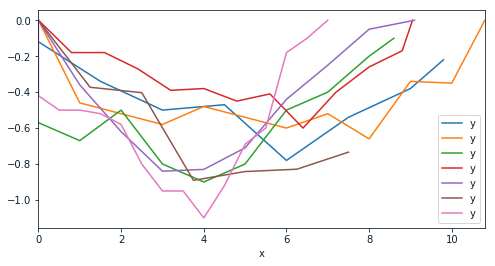

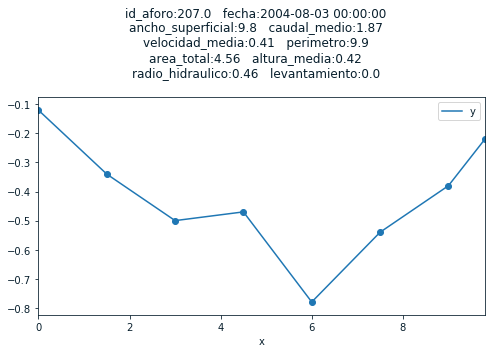

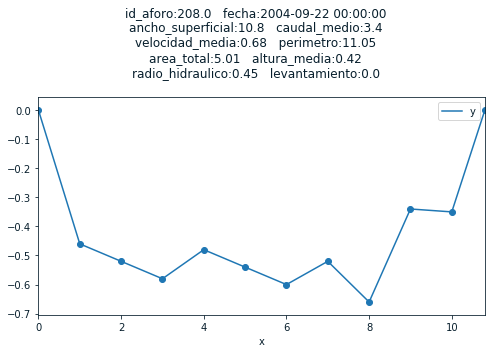

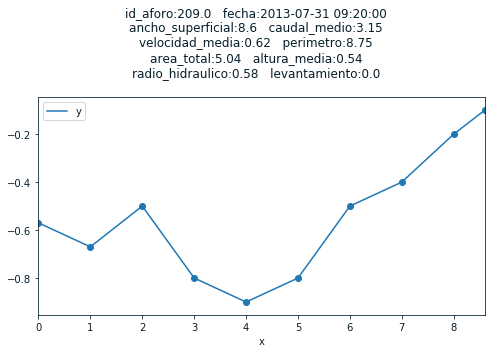

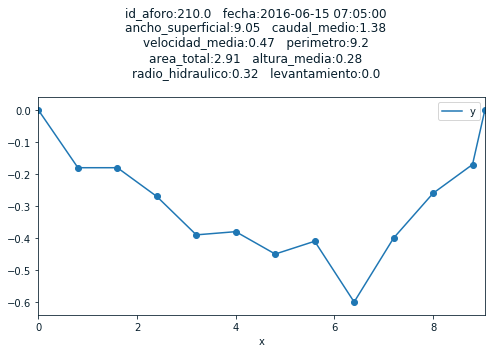

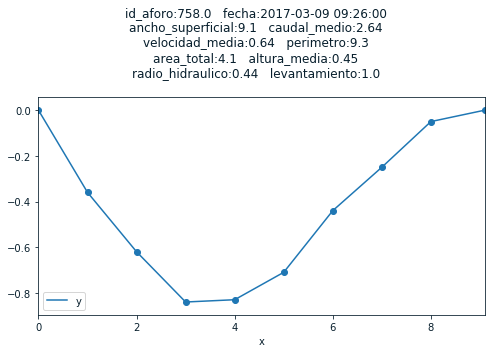

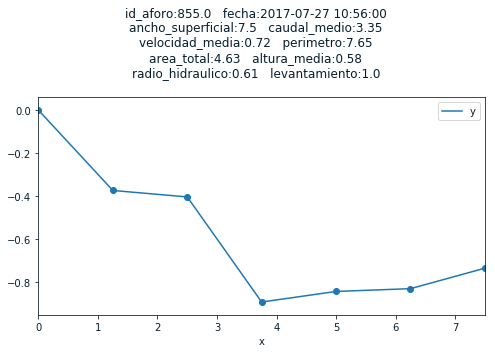

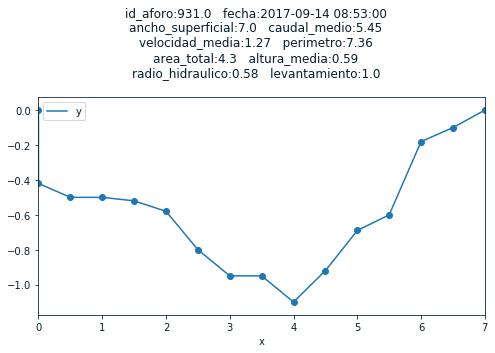

In [11]:
plot_sections(self)

In [12]:
aforos.drop('fecha',axis=1).describe()

,ancho_superficial,caudal_medio,velocidad_media,perimetro,area_total,altura_media,radio_hidraulico
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,8.835714,3.033126,0.688509,9.030991,4.365571,0.469614,0.491037
std,1.298305,1.312171,0.278671,1.271925,0.730047,0.109382,0.103785
min,7.000000,1.375630,0.410851,7.359700,2.905250,0.283846,0.315633
25%,8.050000,2.257285,0.548760,8.200890,4.201250,0.419791,0.447462
50%,9.050000,3.148200,0.643777,9.204520,4.560000,0.450824,0.460607
75%,9.450000,3.371745,0.699985,9.600920,4.823125,0.562857,0.580402
max,10.800000,5.449990,1.267440,11.049100,5.045000,0.587333,0.605286


## Aforo


In [13]:
fontsize = 18
font = {'size'   :fontsize}
plt.rc('font', **font)


### gráfica de lluvia

In [14]:
# entrada
fecha = '2018-05-10'
#paths
folder_path = pd.to_datetime(fecha).strftime('%Y%m%d')
filepath = main_path+folder_path+'/lluvia.png'
# dates
end = pd.to_datetime(fecha)+datetime.timedelta(hours=18)
start = end - datetime.timedelta(hours=(18+24-6))
# data
self = cpr.Nivel(codigo=260,user='sample_user',passwd = 's@mple_p@ss',SimuBasin=True)
rain = self.radar_rain(start,end)*12.# convert hourly rain (intensity (mm/h))
rain_vect = self.radar_rain_vect(start,end)
print 'fecha:%s,maximo:%s mm/h,fecha maximo:%s'%(fecha,rain.max(),rain.argmax())

201805070000-201805132355-260-sample_user
201805070000-201805132355-260-sample_user
/media/nicolas/maso/Mario/user_output/radar/201805070000-201805132355-260-sample_user
fecha:2018-05-10,maximo:3.96 mm/h,fecha maximo:2018-05-09 21:15:00


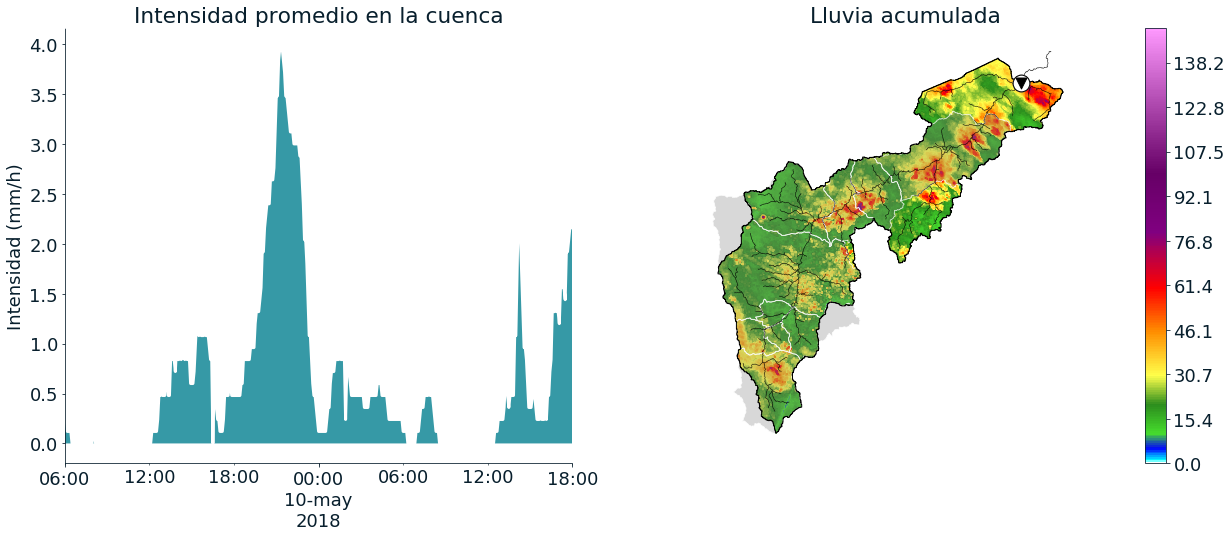

In [15]:
plot_lluvia_redrio(rain,rain_vect,filepath)

# archivos de excel

# Campaña Río

In [16]:
aforos

,fecha,ancho_superficial,caudal_medio,velocidad_media,perimetro,area_total,altura_media,radio_hidraulico,levantamiento
id_aforo,,,,,,,,,
207,2004-08-03 00:00:00,9.80,1.87348,0.410851,9.89999,4.56000,0.418750,0.460607,False
208,2004-09-22 00:00:00,10.80,3.39615,0.677198,11.04910,5.01500,0.420833,0.453884,False
209,2013-07-31 09:20:00,8.60,3.14820,0.624024,8.75044,5.04500,0.544000,0.576542,False
210,2016-06-15 07:05:00,9.05,1.37563,0.473497,9.20452,2.90525,0.283846,0.315633,False
758,2017-03-09 09:26:00,9.10,2.64109,0.643777,9.30185,4.10250,0.450824,0.441041,True
855,2017-07-27 10:56:00,7.50,3.34734,0.722773,7.65134,4.63125,0.581714,0.605286,True
931,2017-09-14 08:53:00,7.00,5.44999,1.267440,7.35970,4.30000,0.587333,0.584263,True


In [17]:
df = pd.read_excel(main_path+'20180426/clasificacion.xlsx')

In [18]:
print(list(df.columns))

[u'Codigo', u'Estaci\xf3n', u'Ancho (m)', u'Profundidad Media (m)', u'\xc1rea (m2)', u'Velocidad (m/s)', u'Caudal (m3/s)', u'Perimetro mojado (m)', u'Radio hidr\xe1ulico (m)', 'Unnamed: 9']


In [19]:
df.columns = [u'Código', u'Estación', u'Ancho (m)', u'Profundidad Media (m)', u'área (m2)', u'Velocidad (m/s)', u'Caudal (m3/s)', u'Perímetro mojado (m)', u'Radio hidráulico (m)', u'Régimen']

In [20]:
columns = ['Caudal medio','Velocidad media','Área','Perímetro','Altura media','Rádio hidráulico']
cellwidth = [30]+6*[70/6]


In [21]:
cellwidth

[30, 11, 11, 11, 11, 11, 11]

In [22]:
df.columns

Index([u'Código', u'Estación', u'Ancho (m)', u'Profundidad Media (m)',
       u'área (m2)', u'Velocidad (m/s)', u'Caudal (m3/s)',
       u'Perímetro mojado (m)', u'Radio hidráulico (m)', u'Régimen'],
      dtype='object')

In [23]:
def plot_bars(s,filepath,bar_fontsize=14,decimales=2,xfactor =1.005,yfactor=1.01):
    plt.figure(figsize=(20,6))
    s = df.drop([9,12,13,14]).set_index(u'Estación')[u'Caudal (m3/s)']
    ax = s.plot(kind='bar')

    ax.set_ylim(s.min()*0.01,s.max()*1.01)
    for container in ax.containers:
              plt.setp(container, width=0.8)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),decimales)),
                    (p.get_x() * xfactor, p.get_height() * yfactor),
                    fontsize = bar_fontsize)
    for j in ['top','right']:
        ax.spines[j].set_edgecolor('white')
    ax.set_ylabel(r'$Caudal\ [m^3/s]$')
    plt.savefig(filepath,bbox_inches='tight')

In [24]:
df[df.columns[1]].values

array([u'Reserva', u'San Miguel', u'Primavera', u'Ancon Sur',
       u'Antes de San fernando', u'Despues de san fernando',
       u'Aula ambiental', u'Puente Acevedo', u'Puente Machado', u'Q rodas',
       u'Niquia', u'Ancon Norte', u'Hatillo', u'Tasajera',
       u'Afluentes entre hatillo y parque', u'Parque de las Aguas',
       u'Papelsa', u'Puente Gabino'], dtype=object)

In [25]:
ids_estaciones_rio = [169,1106,1013,167,1044,94,99,1054,1046,1062,1042,1063,1006]

In [26]:
info.loc[2000] = np.NaN

In [27]:
info.loc[2000,'Nombre'] = 'Hatillo'

In [28]:
s = df.set_index(u'Estación')[u'Caudal (m3/s)']

In [29]:
folder_path = 'redrio/20180426'

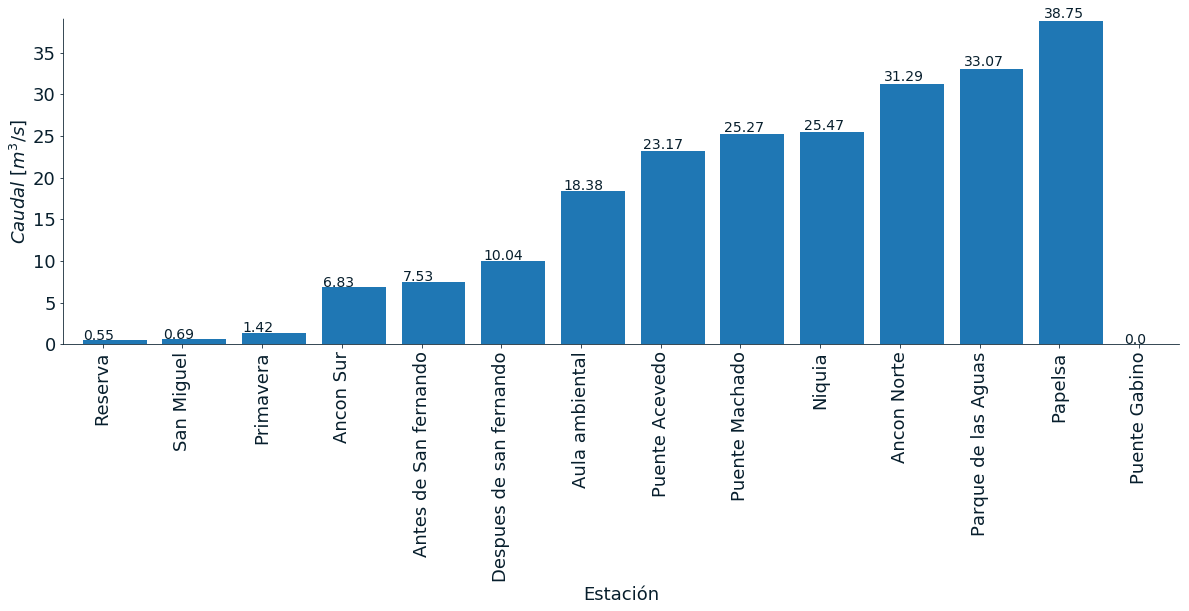

In [30]:
plot_bars(s,folder_path+'resumen.png')

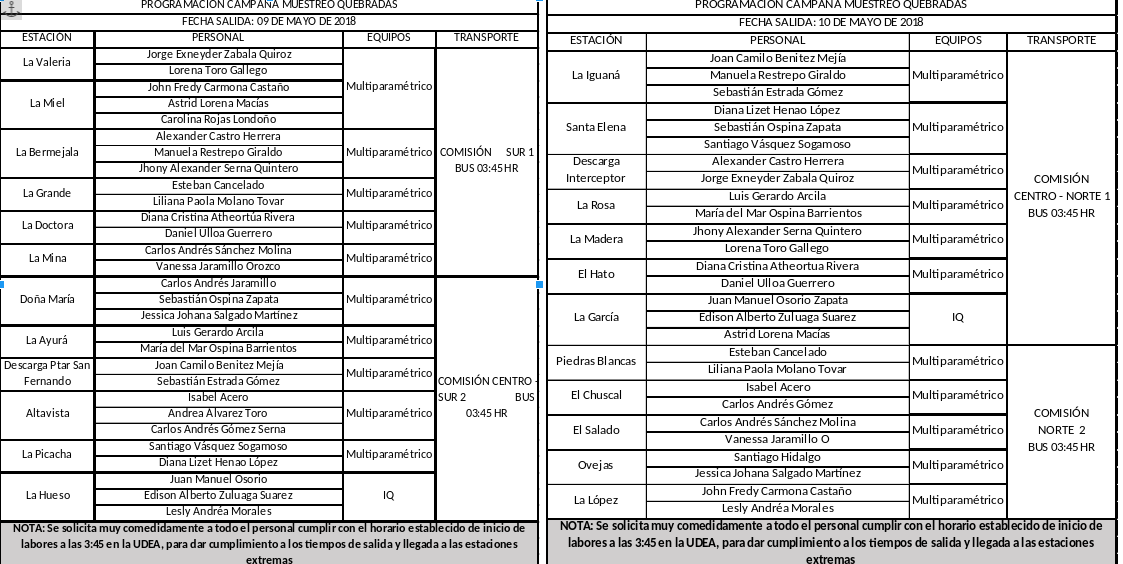

In [31]:
estaciones_rio = [1106,169,1013,167,1044,94,99,1054,1046,1058,1062,1042,2000,2001,2002,2003,1006,1061]
estaciones_sur = [1009,1000,1027,181,1023,1014,1020,1012,1060,1053,1007,1090]
estaciones_norte = [1059,1024,1051,1052,155,1011,1026,1047,1055,1022,1010]

In [32]:
info.loc[2003] = np.NaN
info.loc[2003,'Nombre'] = 'Parque de las Aguas'

In [33]:
info.loc[estaciones_rio,'Nombre'].values

array(['Reserva (E0)', 'San Miguel (E1)', 'Primavera (E2)',
       'Anc\xc3\xb3n Sur (E3)', 'Antes de San Fernando (E5)',
       'Despu\xc3\xa9s de San Fernando (E6)', 'Aula Ambiental (E8)',
       'Puente Acevedo (E9)', 'Puente Machado (E11)', 'Q. Rodas',
       'Niqu\xc3\xada (E21)', 'Anc\xc3\xb3n Norte (E12)', 'Hatillo', nan,
       nan, 'Parque de las Aguas', 'Papelsa (E16)', 'Puente Gabino (E20)'], dtype=object)

In [34]:
df.index = info.loc[estaciones_rio,'Nombre'].values

In [35]:
df = df.drop(df.columns[:2],axis=1)

In [36]:
def to_number(value):
    try:
        value = float(value)
    except:
        value = np.NaN
    return value
        

In [37]:
temp = df[df.columns[:-1]].applymap(lambda x:to_number(x))
temp[df.columns[-1]] = df[df.columns[-1]]

In [38]:
temp = temp.fillna('')

In [39]:
temp

,Ancho (m),Profundidad Media (m),área (m2),Velocidad (m/s),Caudal (m3/s),Perímetro mojado (m),Radio hidráulico (m),Régimen
Reserva (E0),5.6,0.136,0.7616,0.725,0.55216,5.725,0.133031,
San Miguel (E1),3.7,0.359,1.3283,0.52,0.690716,4.275,0.310713,medio
Primavera (E2),6.3,0.303,1.9089,0.744,1.42022,6.921,0.275813,medio
Ancón Sur (E3),14.9,0.706,10.5194,0.649,6.82709,16.491,0.637887,alto
Antes de San Fernando (E5),21,0.421,8.841,0.852,7.53253,21.897,0.403754,medio
Después de San Fernando (E6),19.1,0.619,11.8229,0.849,10.0376,19.803,0.597026,medio
Aula Ambiental (E8),34,0.5461,18.5674,0.99,18.3817,34.992,0.530618,medio
Puente Acevedo (E9),44,0.5805,25.542,0.907,23.1666,38.78,0.658638,medio
Puente Machado (E11),21,1.2638,26.5398,0.952,25.2659,21.412,1.23948,medio
Q. Rodas,2.7,0.1683,0.45441,0.455,0.206757,2.797,0.162463,


In [40]:
for i in latex_table_from_df(self,df,'aqui va el caption','aqui va el label',list(df.columns),[30]+7*[70/7],8):
    print i

\begin{table}[h!]
\caption{aqui va el caption}
\vspace{0.1mm}
\fontsize{10}{2} \selectfont{
\scalebox{1.0}{\begin{tabularx}{\textwidth}{p{2.400 in} p{0.800 in} p{0.800 in} p{0.800 in} p{0.800 in} p{0.800 in} p{0.800 in} p{0.800 in} }
\rowcolor{CiceBlue2}
\rowcolor{CiceBlue2}
\textbf{\textcolor{white}{}}
& \textbf{\textcolor{white}{Ancho (m)}} & \textbf{\textcolor{white}{Profundidad Media (m)}} & \textbf{\textcolor{white}{área (m2)}} & \textbf{\textcolor{white}{Velocidad (m/s)}} & \textbf{\textcolor{white}{Caudal (m3/s)}} & \textbf{\textcolor{white}{Perímetro mojado (m)}} & \textbf{\textcolor{white}{Radio hidráulico (m)}} & \textbf{\textcolor{white}{Régimen}} 
\rule[-0.1cm]{0cm}{0.7cm}\\
\textbf{Reserva (E0)}
& 5.60 & 0.14 & 0.76 & 0.72 & 0.55 & 5.72 & 0.13 & -999.00 
\rule[-0.1cm]{0cm}{0.7cm}\\ \cline{1-9}
\textbf{San Miguel (E1)}
& 3.70 & 0.36 & 1.33 & 0.52 & 0.69 & 4.28 & 0.31 
\rule[-0.1cm]{0cm}{0.7cm}\\ \cline{1-9}
\textbf{Primavera (E2)}
& 6.30 & 0.30 & 1.91 & 0.74 & 1.42 & 6.92 &

# campaña Sur

In [45]:
fecha = '2018-05-09'

In [46]:
estaciones_sur

[1009, 1000, 1027, 181, 1023, 1014, 1020, 1012, 1060, 1053, 1007, 1090]

In [47]:
df = pd.DataFrame(index = info.loc[estaciones_sur,'Nombre'].values,columns = df.columns)

In [48]:
excel_files = []
folder_path = '%s%s/'%(main_path,pd.to_datetime(fecha).strftime('%Y%m%d'))
for file in os.listdir(folder_path):
    if file[-4:] == 'xlsx':
        excel_files.append('%s%s'%(folder_path,file))

Problemas de borde en el levantamiento en banca izquierda


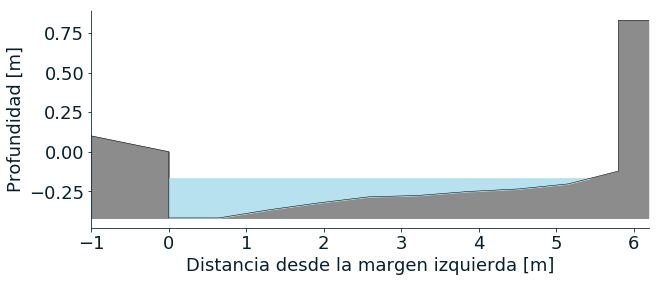

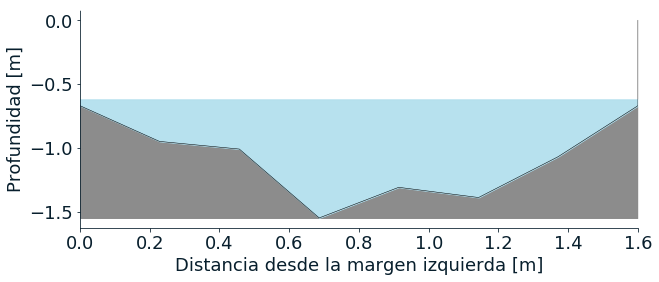

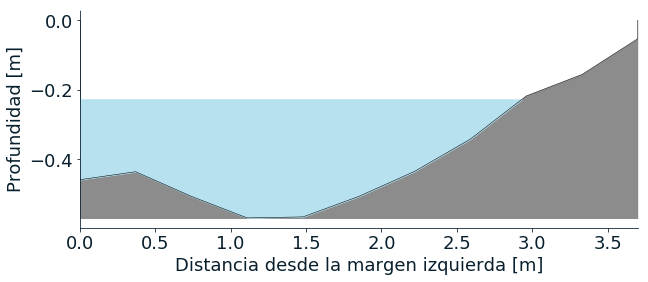

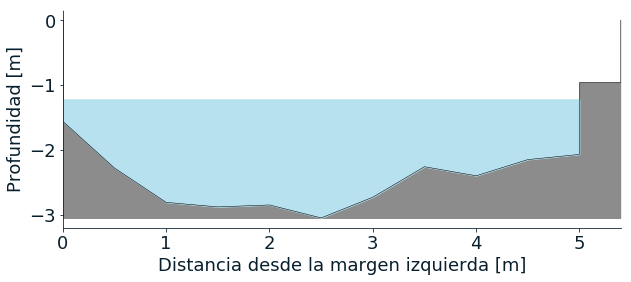

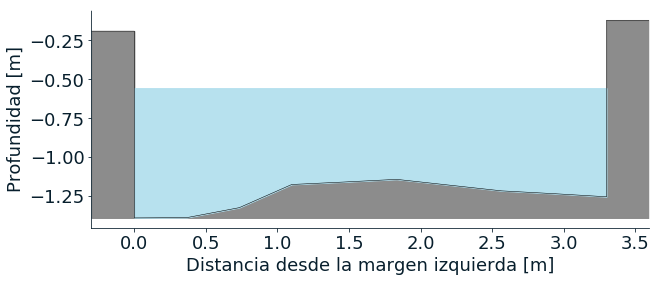

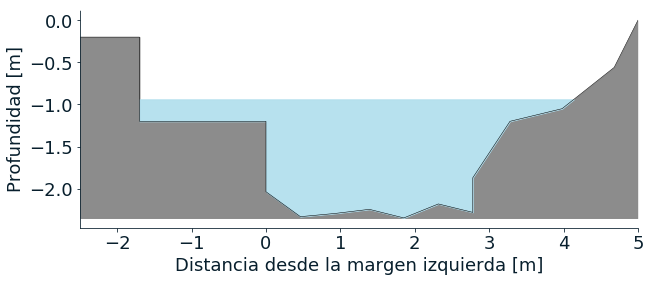

In [49]:
for file in excel_files:
    info_aforo = pd.read_excel(file,sheetname=1)
    info_aforo = info_aforo.set_index('Codigo').loc[['Fecha','hora inicial','hora final','x_lamina (toma profundidad redrio)','y_lamina (toma profundidad redrio)']]
    lev = pd.read_excel(file,sheetname=2)
    lev.columns = map(lambda x:x.lower(),lev.columns)
    plot_section(lev[['x','y']],level=lev['y'].min()*0.4,groundColor='grey',waterColor=self.colores_siata[0])